# import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import scipy.stats as st
import random
from tqdm import tqdm

from model import *
from dataset import *
from utils import *

In [2]:
hyperparams = {
        'n_tasks': 1000,
        'n_episode': 150,
        'n_timesteps': 10,
        'input_dim': 2, 
        'hidden_dim': 512,
        'output_dim': 2,
        'lr': 1e-4,
        'batch_size': 128,
        'n_epochs': 100,
        }

# Load model

In [3]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
def load_model(n_particle=1):
    model = MyModel(input_dim=hyperparams['input_dim'], hidden_dim=hyperparams['hidden_dim'],
                    output_dim=hyperparams['output_dim'], n_particle=n_particle).to(device)
    checkpoint = torch.load('Task1_multiTask.pth.tar', map_location=device)
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()
    return model

# Load data

In [4]:
dataset = torch.load('./two_links_arm_test')
adapt_data = [data['adapt'] for data in dataset]
test_data = [data['test'] for data in dataset]

In [18]:
adapt_data[0]['angle'][:,0].shape

torch.Size([2])

In [19]:
mask = torch.ones(size=(20,512), dtype=torch.float32, requires_grad=False)

In [30]:
a = torch.rand(size=(1,512))

In [31]:
(a * mask).shape

torch.Size([20, 512])

either one x, multiple mask(multiple particle moving), either a batch of x, one mask(one best particle moving)

# Adaptation 

In [16]:
def smcd(T, N, adapt_data, d=0.05):
    '''
    model: neural network
    T: adaptation timestep
	N: particle numbers
	adapt_data: as name
	d: flip rate
	'''
    model = load_model(n_particle=N)
    q = adapt_data['angle']
    # z = adapt_data['noisy_pos']
    z = adapt_data['true_pos']
    n_features = model.get_dropout_mask().shape[1]
	# initialize M_0
    # M = np.random.randint(low=0,high=2,size=(n_features, N))
    M = np.ones((n_features, N), dtype=np.int8)
    M_best = np.ones(n_features)
    assert T <= q.shape[-1], f'T should be less than {q.shape[-1]}'
    assert not model.training, f'please call model.eval()'
    M_bests = []
    for t in tqdm(range(T)):
        M = flip(M,d)
        M[:,0] = M_best # replace one particle by the last best one (no mutation for the last champion particle)
        # w = []
        model.update_dropout_mask(M.swapaxes(1,0))
        X = model(q[:,t].to(device, dtype=torch.float32)).detach().numpy()
        # for i in range(N):
        #     w_i = st.multivariate_normal.pdf(z[:,t].detach().numpy(), mean=X[i], cov=0.001)
        #     w.append(w_i)
        # to benefit from vectorization we replace p(z_t|x_i) by p(x_i|z_t)
        logW = st.multivariate_normal.logpdf(X, mean=z[:,t].detach().numpy(), cov=0.0001)
        W = exp_and_normalise(logW)
        # print(W.shape)
        # print(w)
        # N_eff = int(1 / np.sum((np.asarray(w)) ** 2))
        # print(N_eff)
        if W.sum() != 0: #if w not valid, no update for M_best
            resample_index = resample(range(N), W)
            M = np.take(M, resample_index, axis=1)
            M_best = (M.mean(axis=1) > 0.5).astype(np.int_)
        M_bests.append(M_best)
    return M_bests

In [9]:
def smcd(model: MyModel, T, N, adapt_data, d=0.05):
    '''
    model: neural network
    T: adaptation timestep
	N: particle numbers
	adapt_data: as name
	d: flip rate
	'''
    q = adapt_data['angle']
    # z = adapt_data['noisy_pos']
    z = adapt_data['true_pos']
    n_features = model.get_dropout_mask().shape[0]
	# initialize M_0
    # M = np.random.randint(low=0,high=2,size=(n_features, N))
    M = np.ones((n_features, N), dtype=np.int8)
    M_best = np.ones(n_features)
    assert T <= q.shape[-1], f'T should be less than {q.shape[-1]}'
    assert not model.training, f'please call model.eval()'
    M_bests = []
    for t in tqdm(range(T)):
        M = flip(M,d)
        M[:,0] = M_best # replace one particle by the last best one (no mutation for the last champion particle)
        w = []
        for i in range(N):
            model.update_dropout_mask(M[:,i])
            x_i = model(q[:,t].to(device, dtype=torch.float32)).detach().numpy()
            w_i = st.multivariate_normal.pdf(z[:,t].detach().numpy(), mean=x_i, cov=0.001)
            w.append(w_i)
        # print(w)
        # N_eff = int(1 / np.sum((np.asarray(w)) ** 2))
        # print(N_eff)
        if sum(w) != 0:
            resample_index = resample(range(N), w)
            M = np.take(M, resample_index, axis=1)
            M_best = (M.mean(axis=1) > 0.5).astype(np.int_)
        M_bests.append(M_best)
    return M_bests

In [21]:
def adapt_smcd(adapt_timestep=10, n_particles=300):
    losses = []
    losses_no_adaptation = []
    criterion = nn.MSELoss()
    M_best_per_task = []
    for i in range(len(adapt_data)):
        model = load_model()
        q = adapt_data[i]['angle'].to(torch.float32).swapaxes(1,0)
        x = adapt_data[i]['true_pos'].to(torch.float32).swapaxes(1,0)
        x_noadapt = model(q).detach()
        
        M_best = smcd(adapt_timestep, n_particles, adapt_data[i], d=0.15)
        M_best_per_task.append(M_best[-1].reshape(1,-1))
        model.update_dropout_mask(M_best[-1].reshape(1,-1))
        x_pred = model(q).detach()
        
        loss = criterion(x_pred, x)
        loss_no_adapt = criterion(x_noadapt, x)
        # print(f"For {i}th task, loss after adaptation is {round(loss.item(), 3)}, limb length is {dataset.l[i]}")
        # print(f"For {i}th task, loss after adaptation is {round(loss.item(), 3)}, No adaptation loss is {round(loss_no_adapt.item(), 3)}, limb length is {dataset.l[i]}")
        print(f"For {i}th task, loss after adaptation is {round(loss.item(), 3)}, No adaptation loss is {round(loss_no_adapt.item(), 3)}")
        losses.append(loss)
        losses_no_adaptation.append(loss_no_adapt)
    return losses, losses_no_adaptation, M_best_per_task

In [22]:
losses, losses_no_adaptation, M_best_per_task = adapt_smcd(100, 1000)

100%|██████████| 100/100 [00:03<00:00, 32.72it/s]


For 0th task, loss after adaptation is 1.575, No adaptation loss is 1.522


100%|██████████| 100/100 [00:02<00:00, 35.90it/s]


For 1th task, loss after adaptation is 0.77, No adaptation loss is 0.823


100%|██████████| 100/100 [00:02<00:00, 35.30it/s]


For 2th task, loss after adaptation is 0.404, No adaptation loss is 0.629


100%|██████████| 100/100 [00:02<00:00, 36.76it/s]


For 3th task, loss after adaptation is 0.088, No adaptation loss is 0.454


100%|██████████| 100/100 [00:02<00:00, 34.63it/s]


For 4th task, loss after adaptation is 1.836, No adaptation loss is 2.0


100%|██████████| 100/100 [00:02<00:00, 36.51it/s]


For 5th task, loss after adaptation is 1.293, No adaptation loss is 1.34


100%|██████████| 100/100 [00:02<00:00, 34.67it/s]


For 6th task, loss after adaptation is 0.707, No adaptation loss is 0.913


100%|██████████| 100/100 [00:02<00:00, 35.13it/s]


For 7th task, loss after adaptation is 1.077, No adaptation loss is 1.172


100%|██████████| 100/100 [00:02<00:00, 37.09it/s]


For 8th task, loss after adaptation is 0.466, No adaptation loss is 0.784


100%|██████████| 100/100 [00:02<00:00, 35.59it/s]


For 9th task, loss after adaptation is 0.253, No adaptation loss is 0.398


100%|██████████| 100/100 [00:02<00:00, 37.68it/s]


For 10th task, loss after adaptation is 0.861, No adaptation loss is 0.88


100%|██████████| 100/100 [00:02<00:00, 37.14it/s]


For 11th task, loss after adaptation is 0.909, No adaptation loss is 1.023


100%|██████████| 100/100 [00:02<00:00, 38.45it/s]


For 12th task, loss after adaptation is 1.107, No adaptation loss is 1.131


100%|██████████| 100/100 [00:02<00:00, 36.73it/s]


For 13th task, loss after adaptation is 0.809, No adaptation loss is 0.923


100%|██████████| 100/100 [00:02<00:00, 38.86it/s]


For 14th task, loss after adaptation is 0.415, No adaptation loss is 0.783


100%|██████████| 100/100 [00:02<00:00, 36.36it/s]


For 15th task, loss after adaptation is 0.606, No adaptation loss is 0.722


100%|██████████| 100/100 [00:02<00:00, 39.09it/s]


For 16th task, loss after adaptation is 0.866, No adaptation loss is 0.973


100%|██████████| 100/100 [00:02<00:00, 38.48it/s]


For 17th task, loss after adaptation is 1.206, No adaptation loss is 1.278


100%|██████████| 100/100 [00:02<00:00, 37.81it/s]


For 18th task, loss after adaptation is 0.959, No adaptation loss is 1.021


100%|██████████| 100/100 [00:02<00:00, 36.65it/s]


For 19th task, loss after adaptation is 1.587, No adaptation loss is 1.573


100%|██████████| 100/100 [00:02<00:00, 38.09it/s]


For 20th task, loss after adaptation is 1.022, No adaptation loss is 1.053


100%|██████████| 100/100 [00:02<00:00, 39.17it/s]


For 21th task, loss after adaptation is 0.972, No adaptation loss is 1.111


100%|██████████| 100/100 [00:02<00:00, 37.90it/s]


For 22th task, loss after adaptation is 0.775, No adaptation loss is 1.261


100%|██████████| 100/100 [00:02<00:00, 37.07it/s]


For 23th task, loss after adaptation is 0.864, No adaptation loss is 0.965


100%|██████████| 100/100 [00:02<00:00, 36.69it/s]


For 24th task, loss after adaptation is 0.782, No adaptation loss is 0.867


100%|██████████| 100/100 [00:02<00:00, 39.99it/s]


For 25th task, loss after adaptation is 1.041, No adaptation loss is 1.122


100%|██████████| 100/100 [00:02<00:00, 38.39it/s]


For 26th task, loss after adaptation is 0.952, No adaptation loss is 1.325


100%|██████████| 100/100 [00:02<00:00, 39.50it/s]


For 27th task, loss after adaptation is 0.486, No adaptation loss is 1.028


100%|██████████| 100/100 [00:02<00:00, 36.72it/s]


For 28th task, loss after adaptation is 0.818, No adaptation loss is 0.855


100%|██████████| 100/100 [00:02<00:00, 39.87it/s]


For 29th task, loss after adaptation is 1.23, No adaptation loss is 1.172


100%|██████████| 100/100 [00:02<00:00, 37.74it/s]


For 30th task, loss after adaptation is 0.574, No adaptation loss is 0.818


100%|██████████| 100/100 [00:02<00:00, 38.63it/s]


For 31th task, loss after adaptation is 1.377, No adaptation loss is 1.431


100%|██████████| 100/100 [00:02<00:00, 39.09it/s]


For 32th task, loss after adaptation is 0.923, No adaptation loss is 0.92


100%|██████████| 100/100 [00:02<00:00, 38.82it/s]


For 33th task, loss after adaptation is 0.969, No adaptation loss is 1.302


100%|██████████| 100/100 [00:02<00:00, 38.97it/s]


For 34th task, loss after adaptation is 0.734, No adaptation loss is 0.858


100%|██████████| 100/100 [00:02<00:00, 37.52it/s]


For 35th task, loss after adaptation is 1.362, No adaptation loss is 1.374


100%|██████████| 100/100 [00:02<00:00, 37.51it/s]


For 36th task, loss after adaptation is 1.863, No adaptation loss is 1.736


100%|██████████| 100/100 [00:02<00:00, 37.11it/s]


For 37th task, loss after adaptation is 1.737, No adaptation loss is 1.797


100%|██████████| 100/100 [00:02<00:00, 36.32it/s]


For 38th task, loss after adaptation is 0.815, No adaptation loss is 0.96


100%|██████████| 100/100 [00:02<00:00, 35.74it/s]


For 39th task, loss after adaptation is 0.638, No adaptation loss is 0.718


100%|██████████| 100/100 [00:02<00:00, 37.21it/s]


For 40th task, loss after adaptation is 0.662, No adaptation loss is 0.955


100%|██████████| 100/100 [00:02<00:00, 36.89it/s]


For 41th task, loss after adaptation is 1.273, No adaptation loss is 1.423


100%|██████████| 100/100 [00:02<00:00, 36.99it/s]


For 42th task, loss after adaptation is 0.677, No adaptation loss is 0.703


100%|██████████| 100/100 [00:02<00:00, 37.96it/s]


For 43th task, loss after adaptation is 1.023, No adaptation loss is 1.1


100%|██████████| 100/100 [00:02<00:00, 38.34it/s]


For 44th task, loss after adaptation is 0.709, No adaptation loss is 0.825


100%|██████████| 100/100 [00:02<00:00, 39.29it/s]


For 45th task, loss after adaptation is 1.828, No adaptation loss is 1.904


100%|██████████| 100/100 [00:02<00:00, 38.04it/s]


For 46th task, loss after adaptation is 0.733, No adaptation loss is 1.025


100%|██████████| 100/100 [00:02<00:00, 38.32it/s]


For 47th task, loss after adaptation is 0.914, No adaptation loss is 0.913


100%|██████████| 100/100 [00:02<00:00, 37.34it/s]


For 48th task, loss after adaptation is 1.109, No adaptation loss is 1.233


100%|██████████| 100/100 [00:02<00:00, 38.73it/s]


For 49th task, loss after adaptation is 0.751, No adaptation loss is 1.015


100%|██████████| 100/100 [00:02<00:00, 37.86it/s]


For 50th task, loss after adaptation is 1.428, No adaptation loss is 1.393


100%|██████████| 100/100 [00:02<00:00, 39.06it/s]


For 51th task, loss after adaptation is 0.543, No adaptation loss is 0.831


100%|██████████| 100/100 [00:02<00:00, 37.77it/s]


For 52th task, loss after adaptation is 1.047, No adaptation loss is 1.227


100%|██████████| 100/100 [00:02<00:00, 39.25it/s]


For 53th task, loss after adaptation is 1.616, No adaptation loss is 1.587


100%|██████████| 100/100 [00:02<00:00, 36.64it/s]


For 54th task, loss after adaptation is 0.462, No adaptation loss is 0.782


100%|██████████| 100/100 [00:02<00:00, 39.35it/s]


For 55th task, loss after adaptation is 0.959, No adaptation loss is 1.016


100%|██████████| 100/100 [00:02<00:00, 35.86it/s]


For 56th task, loss after adaptation is 1.008, No adaptation loss is 1.106


100%|██████████| 100/100 [00:02<00:00, 37.96it/s]


For 57th task, loss after adaptation is 1.494, No adaptation loss is 1.498


100%|██████████| 100/100 [00:02<00:00, 36.78it/s]


For 58th task, loss after adaptation is 0.97, No adaptation loss is 1.059


100%|██████████| 100/100 [00:02<00:00, 37.11it/s]


For 59th task, loss after adaptation is 0.351, No adaptation loss is 0.631


100%|██████████| 100/100 [00:02<00:00, 37.42it/s]


For 60th task, loss after adaptation is 1.032, No adaptation loss is 1.126


100%|██████████| 100/100 [00:02<00:00, 36.22it/s]


For 61th task, loss after adaptation is 0.964, No adaptation loss is 1.056


100%|██████████| 100/100 [00:02<00:00, 37.47it/s]


For 62th task, loss after adaptation is 0.55, No adaptation loss is 0.763


100%|██████████| 100/100 [00:02<00:00, 35.95it/s]


For 63th task, loss after adaptation is 1.625, No adaptation loss is 1.671


100%|██████████| 100/100 [00:02<00:00, 34.92it/s]


For 64th task, loss after adaptation is 1.058, No adaptation loss is 1.091


100%|██████████| 100/100 [00:02<00:00, 37.24it/s]


For 65th task, loss after adaptation is 0.868, No adaptation loss is 0.912


100%|██████████| 100/100 [00:02<00:00, 38.04it/s]


For 66th task, loss after adaptation is 0.707, No adaptation loss is 0.788


100%|██████████| 100/100 [00:02<00:00, 36.98it/s]


For 67th task, loss after adaptation is 1.093, No adaptation loss is 1.087


100%|██████████| 100/100 [00:02<00:00, 38.02it/s]


For 68th task, loss after adaptation is 0.338, No adaptation loss is 0.548


100%|██████████| 100/100 [00:02<00:00, 38.10it/s]


For 69th task, loss after adaptation is 0.439, No adaptation loss is 0.886


100%|██████████| 100/100 [00:02<00:00, 38.26it/s]


For 70th task, loss after adaptation is 1.172, No adaptation loss is 1.439


100%|██████████| 100/100 [00:02<00:00, 38.21it/s]


For 71th task, loss after adaptation is 1.027, No adaptation loss is 1.061


100%|██████████| 100/100 [00:02<00:00, 38.60it/s]


For 72th task, loss after adaptation is 0.949, No adaptation loss is 1.268


100%|██████████| 100/100 [00:02<00:00, 38.76it/s]


For 73th task, loss after adaptation is 0.415, No adaptation loss is 0.643


100%|██████████| 100/100 [00:02<00:00, 36.68it/s]


For 74th task, loss after adaptation is 1.682, No adaptation loss is 1.944


100%|██████████| 100/100 [00:02<00:00, 36.94it/s]


For 75th task, loss after adaptation is 0.604, No adaptation loss is 0.735


100%|██████████| 100/100 [00:02<00:00, 36.70it/s]


For 76th task, loss after adaptation is 0.404, No adaptation loss is 0.622


100%|██████████| 100/100 [00:02<00:00, 37.33it/s]


For 77th task, loss after adaptation is 2.048, No adaptation loss is 2.159


100%|██████████| 100/100 [00:02<00:00, 35.86it/s]


For 78th task, loss after adaptation is 0.391, No adaptation loss is 0.682


100%|██████████| 100/100 [00:02<00:00, 37.89it/s]


For 79th task, loss after adaptation is 0.988, No adaptation loss is 1.31


100%|██████████| 100/100 [00:02<00:00, 34.42it/s]


For 80th task, loss after adaptation is 0.578, No adaptation loss is 0.682


100%|██████████| 100/100 [00:02<00:00, 37.00it/s]


For 81th task, loss after adaptation is 1.219, No adaptation loss is 1.307


100%|██████████| 100/100 [00:02<00:00, 36.66it/s]


For 82th task, loss after adaptation is 1.225, No adaptation loss is 1.364


100%|██████████| 100/100 [00:02<00:00, 35.50it/s]


For 83th task, loss after adaptation is 0.59, No adaptation loss is 0.787


100%|██████████| 100/100 [00:02<00:00, 35.63it/s]


For 84th task, loss after adaptation is 0.605, No adaptation loss is 0.739


100%|██████████| 100/100 [00:02<00:00, 35.36it/s]


For 85th task, loss after adaptation is 1.034, No adaptation loss is 1.077


100%|██████████| 100/100 [00:02<00:00, 36.25it/s]


For 86th task, loss after adaptation is 0.428, No adaptation loss is 0.673


100%|██████████| 100/100 [00:02<00:00, 36.18it/s]


For 87th task, loss after adaptation is 0.795, No adaptation loss is 1.124


100%|██████████| 100/100 [00:02<00:00, 35.73it/s]


For 88th task, loss after adaptation is 0.597, No adaptation loss is 0.814


100%|██████████| 100/100 [00:02<00:00, 33.64it/s]


For 89th task, loss after adaptation is 0.923, No adaptation loss is 1.067


100%|██████████| 100/100 [00:03<00:00, 31.80it/s]


For 90th task, loss after adaptation is 1.007, No adaptation loss is 1.146


100%|██████████| 100/100 [00:02<00:00, 36.00it/s]


For 91th task, loss after adaptation is 1.224, No adaptation loss is 1.408


100%|██████████| 100/100 [00:02<00:00, 36.47it/s]


For 92th task, loss after adaptation is 0.8, No adaptation loss is 0.986


100%|██████████| 100/100 [00:02<00:00, 36.99it/s]


For 93th task, loss after adaptation is 0.43, No adaptation loss is 0.556


100%|██████████| 100/100 [00:02<00:00, 36.30it/s]


For 94th task, loss after adaptation is 1.214, No adaptation loss is 1.138


100%|██████████| 100/100 [00:02<00:00, 36.41it/s]


For 95th task, loss after adaptation is 0.391, No adaptation loss is 0.582


100%|██████████| 100/100 [00:02<00:00, 36.14it/s]


For 96th task, loss after adaptation is 1.091, No adaptation loss is 1.183


100%|██████████| 100/100 [00:02<00:00, 36.59it/s]


For 97th task, loss after adaptation is 0.269, No adaptation loss is 0.563


100%|██████████| 100/100 [00:02<00:00, 36.64it/s]


For 98th task, loss after adaptation is 0.751, No adaptation loss is 0.98


100%|██████████| 100/100 [00:02<00:00, 36.15it/s]

For 99th task, loss after adaptation is 1.941, No adaptation loss is 1.958


In [23]:
np.save('loss_smcd',losses)
np.save('loss_N',losses_no_adaptation)

In [24]:
import numpy as np
import matplotlib.pyplot as plt
loss_smcd = np.load('loss_smcd.npy')
loss_N = np.load('loss_N.npy')

In [25]:
loss_N.mean()

1.071675

In [26]:
loss_smcd.mean()

0.9274951

In [27]:
ind = np.argsort(loss_smcd)

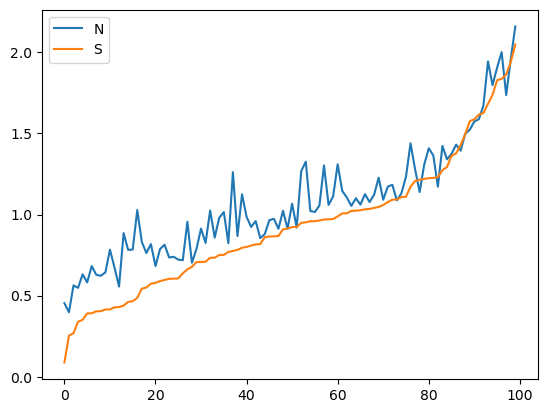

In [29]:
plt.plot(loss_N[ind], label='N')
plt.plot(loss_smcd[ind], label='S')
plt.legend()

# Prediction

In [9]:
test_data[0].keys()

dict_keys(['init_angle', 'init_pos', 'target_pos', 'true_pos', 'noisy_pos'])

In [27]:
def plot_trace(t, start=0, end=-1):
	init_pos = t['init_pos'].numpy()
	target_pos = t['target_pos'].numpy()
	true_pos = t['true_pos'].numpy()
	plt.figure()
	plt.scatter(*init_pos, label='init_pos')
	plt.scatter(*target_pos, label='target_pos')
	plt.plot(true_pos[start:end,0], true_pos[start:end,1], label='true_pos')
	plt.legend()

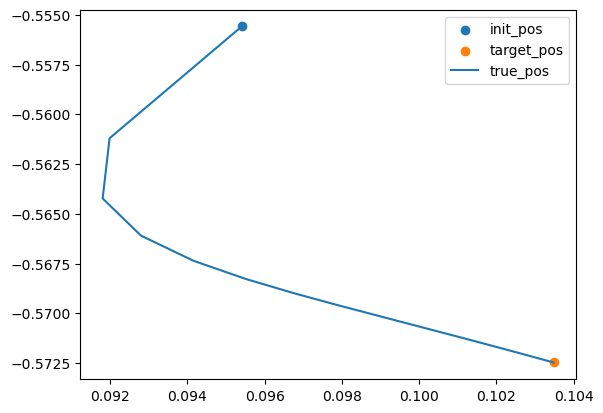

In [37]:
plot_trace(test_data[99], 0, 200)

In [148]:
def test_smcd(mask_per_task, n_tasks = -1):
	trace_pred = []
	trace_true = []
	criterion = nn.MSELoss()
	with tqdm(test_data[0:n_tasks], unit='task')as tepoch:
		for i, task in enumerate(tepoch):
			trace_pred_i = np.array([])
			trace_true_i = np.array([])
			model = load_model()
			q0 = task['init_angle'].to(dtype=torch.float32)
			xg = task['target_pos']
			x_oracle = task['true_pos']
			model.update_dropout_mask(mask_per_task[i])
			q = q0
			u = 0
			l = dataset.l[i]
			x0 = task['init_pos']
			x0_pred = model(q0)
			loss = criterion(x0_pred, x0)
			print(loss)
			for t in range(len(x_oracle)):
				x_pred = model(q).detach()
				x_true = fk(q, l)
				# emit control from predicted position
				u = pd(q, x_pred, xg, u, k=[1,1e-2], l=l)
				q += u
				# normalize
				q = np.mod(q, 2 * np.pi)
				q[q>np.pi] -= 2*np.pi
				# the system evolve subject to control and real setting
				# print(x_pred)
				# print(x_true)
				trace_pred_i = np.append(trace_pred_i, x_pred.numpy(), axis=0)
				trace_true_i = np.append(trace_true_i, x_true, axis=0)
			trace_pred.append(trace_pred_i.reshape(-1,2))
			trace_true.append(trace_true_i.reshape(-1,2))
	return trace_pred, trace_true


In [156]:
q = np.pi + 1
np.mod(q, 2 * np.pi) - np.pi

1.0

In [149]:
trace_pred, trace_true = test_smcd(M_best_per_task, 5)

  0%|          | 0/5 [00:00<?, ?task/s]

tensor(0.2336, dtype=torch.float64, grad_fn=<MseLossBackward0>)


 20%|██        | 1/5 [00:00<00:01,  2.43task/s]

tensor(0.0029, dtype=torch.float64, grad_fn=<MseLossBackward0>)


 40%|████      | 2/5 [00:00<00:01,  2.67task/s]

tensor(0.0099, dtype=torch.float64, grad_fn=<MseLossBackward0>)


 60%|██████    | 3/5 [00:01<00:00,  2.62task/s]

tensor(0.8566, dtype=torch.float64, grad_fn=<MseLossBackward0>)


 80%|████████  | 4/5 [00:01<00:00,  2.39task/s]

tensor(0.0810, dtype=torch.float64, grad_fn=<MseLossBackward0>)


100%|██████████| 5/5 [00:01<00:00,  2.50task/s]


In [150]:
trace_true[0].shape
len(trace_true)

5

In [151]:
def plot_trace(i, start=0, end=-1):
	t = test_data[i]
	init_pos = t['init_pos'].numpy()
	target_pos = t['target_pos'].numpy()
	true_pos = t['true_pos'].numpy()
	plt.figure()
	plt.scatter(*init_pos, label='init_pos')
	plt.scatter(*trace_true[i][start], marker='o')
	plt.scatter(*trace_pred[i][start], marker='o')
	plt.scatter(*trace_true[i][end], marker='^')
	plt.scatter(*trace_pred[i][end], marker='^')
	plt.plot(true_pos[start:end,0], true_pos[start:end,1], label='oracle_pos')
	plt.plot(trace_true[i][start:end,0], trace_true[i][start:end,1], label='true_pos')
	plt.plot(trace_pred[i][start:end,0], trace_pred[i][start:end,1], label='pred_pos')
	plt.scatter(*target_pos, label='target_pos')
	plt.legend()

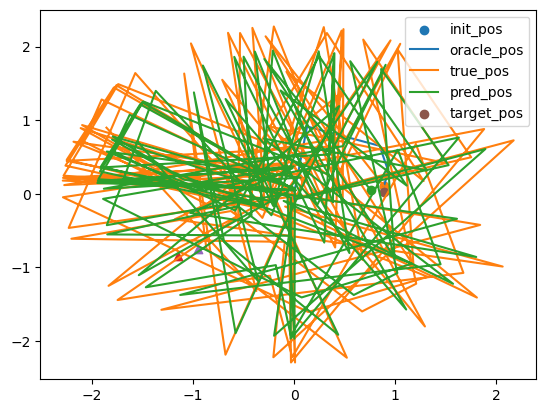

In [154]:
plot_trace(2, 0, 100)